In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../..")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from librep.datasets.har.loaders import (
    KuHar_BalancedView20HzMotionSenseEquivalent
)

2022-11-10 19:34:48.491531: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-10 19:34:48.491552: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
from librep.transforms.topo_ae import (
    TopologicalDimensionalityReduction,
    ConvolutionalTopologicalDimensionalityReduction,
    CustomTopoDimRedTransform
)
from librep.transforms import UMAP
from sklearn.manifold import TSNE
from experiments.Topological_ae.Experiment_utils import *
from librep.datasets.multimodal import TransformMultiModalDataset
from librep.transforms.fft import FFT

In [6]:
# MotionSense Loader
loader = KuHar_BalancedView20HzMotionSenseEquivalent(
    root_dir="../../../data/views/KuHar/balanced_20Hz_motionsense_equivalent-v1", 
    download=False
)

# Print the readme (optional)
loader.print_readme()

# Balanced KuHar View Resampled to 20Hz

This is a view from [KuHar v5](https://data.mendeley.com/datasets/45f952y38r/5) that was spllited into 3s windows and was resampled to 20Hz using the [FFT method](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html#scipy.signal.resample). 

The data was first splitted in three sets: train, validation and test. Each one with the following proportions:
- Train: 70% of samples
- Validation: 10% of samples
- Test: 20% of samples

After splits, the datasets were balanced in relation to the activity code column, that is, each subset have the same number of activitiy samples.

**NOTE**: Each subset contain samples from distinct users, that is, samples of one user belongs exclusivelly to one of three subsets.

## Activity codes
- 0: stair down (485 train, 34 validation, 41 test) 
- 1: stair up (485 train, 34 validation, 41 test) 
- 2: sit (485 train, 34 validation, 41 test) 
- 3: stand (485 train, 34 validation, 41 test) 
- 4: walk (485 train, 34 validation, 41 test) 
- 5: run (485 train, 34 validation, 41 test) 
 

## Standartized activity codes
- 0: sit (485 train, 34 validation, 41 test) 
- 1: stand (485 train, 34 validation, 41 test) 
- 2: walk (485 train, 34 validation, 41 test) 
- 3: stair up (485 train, 34 validation, 41 test) 
- 4: stair down (485 train, 34 validation, 41 test) 
- 5: run (485 train, 34 validation, 41 test) 
      




In [7]:
# Load the dataset
# If concat_train_validation is true, return a tuple (train+validation, test)
train_val, test = loader.load(concat_train_validation=True, label=loader.standard_label)
train_val, test

(PandasMultiModalDataset: samples=3114, features=360, no. window=6, label_columns='standard activity code',
 PandasMultiModalDataset: samples=246, features=360, no. window=6, label_columns='standard activity code')

In [8]:
train_HD = np.array(train_val[:][0])
train_Y = np.array(train_val[:][1])
test_HD = np.array(test[:][0])
test_Y = np.array(test[:][1])

In [9]:
print(train_HD.shape, train_Y.shape, test_HD.shape, test_Y.shape)

(3114, 360) (3114,) (246, 360) (246,)


# Aplicar FFT

In [10]:
fft_transform = FFT(centered = True)
transformer = TransformMultiModalDataset(
    transforms=[fft_transform],
    new_window_name_prefix="fft."
)

In [11]:
train_dataset_fft = transformer(train_val)
# validation_dataset_fft = transformer(validation_dataset)
test_dataset_fft = transformer(test)

In [12]:
print(train_dataset_fft.X.shape)
# print(validation_dataset_fft.X.shape)
print(test_dataset_fft.X.shape)

(3114, 180)
(246, 180)


In [13]:
print(np.max(train_dataset_fft.X))

1199.4899017510002


In [14]:
train_dataset_fft.X

array([[ 5.02447148,  1.61251322,  6.76232259, ...,  0.61856338,
         1.44669533,  0.76661466],
       [ 3.57299732, 10.83009996, 11.81552738, ...,  0.33707892,
         0.57328104,  1.73237447],
       [18.92428589, 22.85409918, 26.51434407, ...,  1.28323215,
         0.74769824,  1.31400771],
       ...,
       [37.2112309 , 19.57891073, 22.52651437, ...,  1.15467725,
         1.07398967,  3.41019869],
       [58.00138092, 13.80286188, 11.50619146, ...,  1.93344645,
         6.26234023,  2.55844602],
       [22.52434513, 15.52963032,  4.92321122, ...,  5.31483603,
         3.63845394,  1.15570768]])

In [15]:
train_HD = train_dataset_fft.X
train_LD = None
train_Y = train_dataset_fft.y
test_HD = test_dataset_fft.X
test_LD = None
test_Y = test_dataset_fft.y

In [16]:
print(train_HD.shape, train_Y.shape, test_HD.shape, test_Y.shape)

(3114, 180) (3114,) (246, 180) (246,)


# Visualization helper

In [17]:
# 0: sit (569 train, 101 validation, 170 test)
# 1: stand (569 train, 101 validation, 170 test)
# 2: walk (569 train, 101 validation, 170 test)
# 3: stair up (569 train, 101 validation, 170 test)
# 4: stair down (569 train, 101 validation, 170 test)
# 5: run (569 train, 101 validation, 170 test)
def visualize(X, Y):
    labels = ['sit', 'stand', 'walk', 'stair up', 'stair down', 'run']
    df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=Y))
    groups = df.groupby('label')
    fig, ax = plt.subplots()
    ax.margins(0.05)
    for name, group in groups:
        ax.plot(group.x, group.y, marker='.', linestyle='', ms=8, label=labels[name])
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [18]:
# Variables to reuse
model_dim = 10
model_epc = 125

# Reducing with Convolutional Topological Autoencoders

In [46]:
model_lam = 1
model_dim = 10
model_epc = 125
topo_reducer = ConvolutionalTopologicalDimensionalityReduction(
    ae_model='ConvolutionalAutoencoder_custom_dim2',
    lam=model_lam,
    ae_kwargs={'input_dims': (1, 180), 'custom_dim': model_dim},
    input_shape=(-1, 1, 180),
    patience=None,
    num_epochs=model_epc
)

Topologically Regularized ConvolutionalAutoencoder_custom_dim2
Using python to compute signatures
ConvAECustomDim, Input: (1, 180) Inner dim: 10
ENCODER STRUCT torch.Size([4, 8, 5])


Epoch:1, P:None, Loss:822.0480, Loss-ae:822.0405, Loss-topo:0.0075
Epoch:2, P:None, Loss:816.2276, Loss-ae:816.2270, Loss-topo:0.0005
Epoch:3, P:None, Loss:808.6357, Loss-ae:808.6351, Loss-topo:0.0006
Epoch:4, P:None, Loss:816.1792, Loss-ae:816.1787, Loss-topo:0.0005
Epoch:5, P:None, Loss:817.3291, Loss-ae:817.3282, Loss-topo:0.0009
Epoch:6, P:None, Loss:815.2430, Loss-ae:815.2424, Loss-topo:0.0007
Epoch:7, P:None, Loss:815.0901, Loss-ae:815.0894, Loss-topo:0.0007
Epoch:8, P:None, Loss:810.2714, Loss-ae:810.2710, Loss-topo:0.0004
Epoch:9, P:None, Loss:813.0971, Loss-ae:813.0968, Loss-topo:0.0004
Epoch:10, P:None, Loss:812.4288, Loss-ae:812.4283, Loss-topo:0.0005
Epoch:11, P:None, Loss:814.9439, Loss-ae:814.9435, Loss-topo:0.0005
Epoch:12, P:None, Loss:811.3089, Loss-ae:811.3085, Loss-topo:0.0003
Epoch:13, P:None, Loss:819.6693, Loss-ae:819.6688, Loss-topo:0.0005
Epoch:14, P:None, Loss:813.3521, Loss-ae:813.3516, Loss-topo:0.0005
Epoch:15, P:None, Loss:815.0888, Loss-ae:815.0883, Loss-t

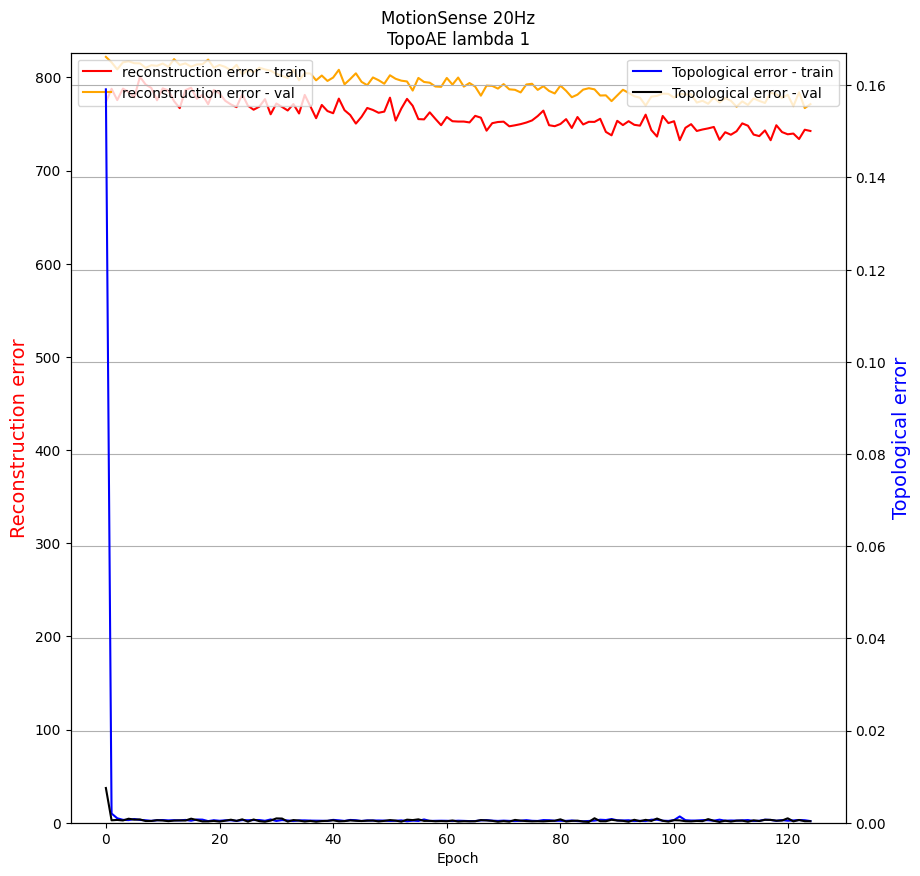

In [47]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [48]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [49]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (3114, 10)
TEST LD RESHAPED (246, 10)


In [50]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.7398373983739838,
 'RF-F1': 0.743336216643622,
 'SVC-ACC': 0.6626016260162602,
 'SVC-F1': 0.717870975550714,
 'KNN-ACC': 0.6829268292682927,
 'KNN-F1': 0.6817563075373851}

## Reconstruction

In [51]:
# print(train_LD.shape)
train_HD_reconstructed = topo_reducer.inverse_transform(train_LD)
test_HD_reconstructed = topo_reducer.inverse_transform(test_LD)

In [52]:
experiments_result = run_experiments(_, train_HD_reconstructed, train_Y, _, test_HD_reconstructed, test_Y)
experiments_result

{'RF-ACC': 0.16666666666666669,
 'RF-F1': 0.2857142857142857,
 'SVC-ACC': 0.16666666666666666,
 'SVC-F1': 0.2857142857142857,
 'KNN-ACC': 0.16666666666666666,
 'KNN-F1': 0.2857142857142857}

# Reducing with Generic Autoencoders

In [26]:
model_lam = 0
topo_reducer = CustomTopoDimRedTransform(
    model_name='DeepAE_custom_dim',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

Topologically Regularized DeepAE_custom_dim
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 180) Inner dim: 10


Epoch:1, P:None, Loss:795.3429, Loss-ae:795.3429, Loss-topo:1.9122
Epoch:2, P:None, Loss:788.8159, Loss-ae:788.8159, Loss-topo:1.8620
Epoch:3, P:None, Loss:797.8786, Loss-ae:797.8786, Loss-topo:1.6893
Epoch:4, P:None, Loss:800.9566, Loss-ae:800.9566, Loss-topo:1.6714
Epoch:5, P:None, Loss:794.5032, Loss-ae:794.5032, Loss-topo:1.7366
Epoch:6, P:None, Loss:787.9054, Loss-ae:787.9054, Loss-topo:1.6236
Epoch:7, P:None, Loss:791.9739, Loss-ae:791.9739, Loss-topo:1.6081
Epoch:8, P:None, Loss:792.6830, Loss-ae:792.6830, Loss-topo:1.4716
Epoch:9, P:None, Loss:801.2374, Loss-ae:801.2374, Loss-topo:1.4202
Epoch:10, P:None, Loss:799.9415, Loss-ae:799.9415, Loss-topo:1.3346
Epoch:11, P:None, Loss:793.1279, Loss-ae:793.1279, Loss-topo:1.1042
Epoch:12, P:None, Loss:796.5847, Loss-ae:796.5847, Loss-topo:1.1166
Epoch:13, P:None, Loss:801.1690, Loss-ae:801.1690, Loss-topo:1.2427
Epoch:14, P:None, Loss:808.6685, Loss-ae:808.6685, Loss-topo:1.4589
Epoch:15, P:None, Loss:794.0844, Loss-ae:794.0844, Loss-t

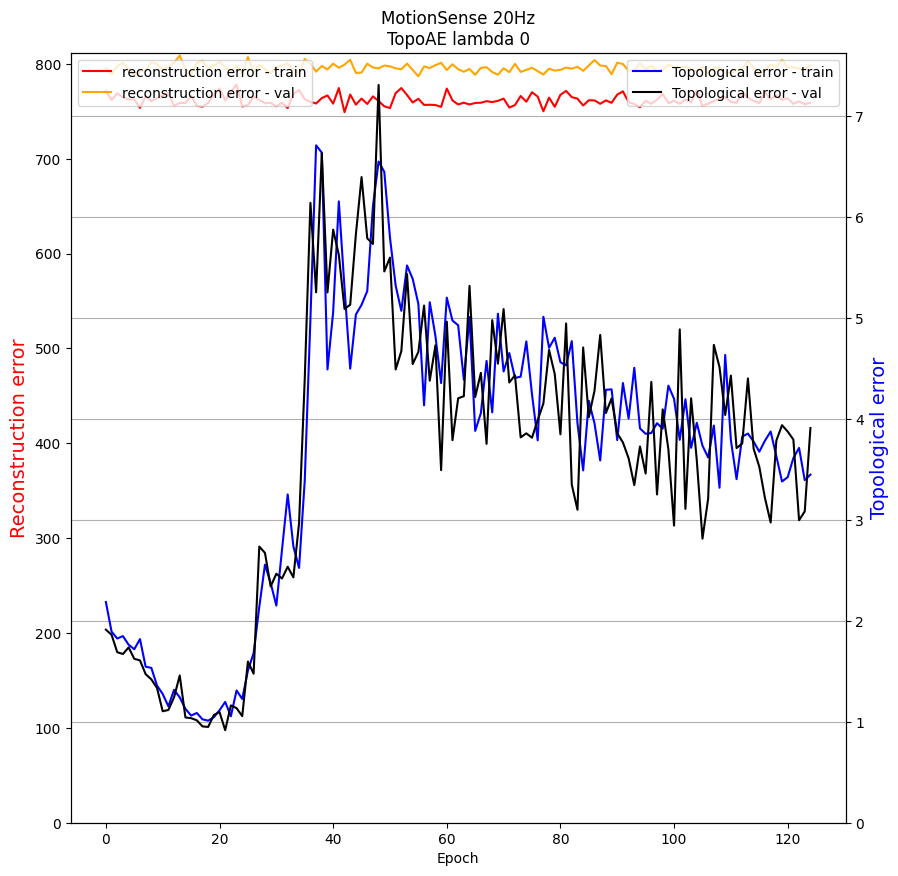

In [27]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [28]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [29]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (3114, 10)
TEST LD RESHAPED (246, 10)


In [30]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.7747967479674797,
 'RF-F1': 0.7756086142129892,
 'SVC-ACC': 0.7154471544715447,
 'SVC-F1': 0.7218905890440518,
 'KNN-ACC': 0.6585365853658537,
 'KNN-F1': 0.6561922733175425}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


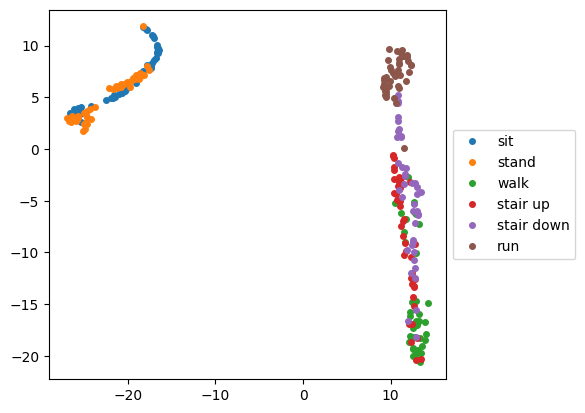

In [31]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

## Reconstruction

In [32]:
# print(train_LD.shape)
train_HD_reconstructed = topo_reducer.inverse_transform(train_LD)
test_HD_reconstructed = topo_reducer.inverse_transform(test_LD)

RuntimeError: running_mean should contain 1 elements not 250

In [ ]:
experiments_result = run_experiments(_, train_HD_reconstructed, train_Y, _, test_HD_reconstructed, test_Y)
experiments_result

# Reducing with Topological Autoencoders (L=1)

In [ ]:
model_lam = 1
topo_reducer = CustomTopoDimRedTransform(
    model_name='DeepAE_custom_dim',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

In [ ]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [ ]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [ ]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

In [ ]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

## Reconstruction

In [ ]:
# print(train_LD.shape)
train_HD_reconstructed = topo_reducer.inverse_transform(train_LD)
test_HD_reconstructed = topo_reducer.inverse_transform(test_LD)

In [ ]:
experiments_result = run_experiments(_, train_HD_reconstructed, train_Y, _, test_HD_reconstructed, test_Y)
experiments_result

In [ ]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

# Reducing with Topological Autoencoders (L=5)

In [ ]:
model_lam = 5
topo_reducer = CustomTopoDimRedTransform(
    model_name='DeepAE_custom_dim',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

In [ ]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [ ]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [ ]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

In [ ]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

## Reconstruction

In [ ]:
# print(train_LD.shape)
train_HD_reconstructed = topo_reducer.inverse_transform(train_LD)
test_HD_reconstructed = topo_reducer.inverse_transform(test_LD)

In [ ]:
experiments_result = run_experiments(_, train_HD_reconstructed, train_Y, _, test_HD_reconstructed, test_Y)
experiments_result

In [ ]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

# Reducing with Topological Autoencoders (L=10)

In [ ]:
model_lam = 10
topo_reducer = CustomTopoDimRedTransform(
    model_name='DeepAE_custom_dim',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

In [ ]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [ ]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [ ]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

In [ ]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

## Reconstruction

In [ ]:
# print(train_LD.shape)
train_HD_reconstructed = topo_reducer.inverse_transform(train_LD)
test_HD_reconstructed = topo_reducer.inverse_transform(test_LD)

In [ ]:
experiments_result = run_experiments(_, train_HD_reconstructed, train_Y, _, test_HD_reconstructed, test_Y)
experiments_result

In [ ]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

# Reducing with Topological Autoencoders (L=100)

In [ ]:
model_lam = 100
topo_reducer = CustomTopoDimRedTransform(
    model_name='DeepAE_custom_dim',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

In [ ]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [ ]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [ ]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

In [ ]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

## Reconstruction

In [ ]:
# print(train_LD.shape)
train_HD_reconstructed = topo_reducer.inverse_transform(train_LD)
test_HD_reconstructed = topo_reducer.inverse_transform(test_LD)

In [ ]:
experiments_result = run_experiments(_, train_HD_reconstructed, train_Y, _, test_HD_reconstructed, test_Y)
experiments_result

In [ ]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)